In [34]:
import pandas as pd
data = pd.read_csv("/Users/kmaran3/Dropbox/MGT6203/TEMP/game_logs.csv")
threshold = len(data.columns) / 2
data = data.dropna(thresh=threshold)
data = data[data['forefeit'].isna()]
if 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'], format='%Y%m%d', errors='coerce')  # Convert to datetime
    data = data[data['date'] > pd.Timestamp('1961-01-01')]

mlb_team_mapping = {
    'CHA': 'CWS', 'LAA': 'LAA', 'KC1': 'KC', 'CLE': 'CLE', 'MIN': 'MIN', 'CHN': 'CHC',
    'PHI': 'PHI', 'SLN': 'STL', 'PIT': 'PIT', 'MLN': 'MIL', 'CIN': 'CIN', 'WS2': 'WSH',
    'DET': 'DET', 'NYA': 'NYY', 'BOS': 'BOS', 'SFN': 'SF', 'BAL': 'BAL', 'LAN': 'LAD',
    'NYN': 'NYM', 'HOU': 'HOU', 'CAL': 'LAA', 'ATL': 'ATL', 'OAK': 'OAK', 'SE1': 'SEA',
    'MON': 'WSH', 'KCA': 'KC', 'SDN': 'SD', 'TOR': 'TOR', 'SEA': 'SEA', 'MIL': 'MIL',
    'TEX': 'TEX', 'COL': 'COL', 'TBA': 'TB', 'FLO': 'MIA', 'ARI': 'ARI', 'ANA': 'LAA',
    'WAS': 'WSH', 'MIA': 'MIA'
}

if 'v_name' in data.columns and 'h_name' in data.columns:
    data['v_name'] = data['v_name'].map(mlb_team_mapping)
    data['h_name'] = data['h_name'].map(mlb_team_mapping)

print("Consolidated unique values in v_name:", data['v_name'].unique())
print("Consolidated unique values in h_name:", data['h_name'].unique())

data = data[["date", "day_of_week", "v_name", "v_game_number", "h_name", "h_game_number", "v_score", 'h_score', "day_night", "attendance"]]

/var/folders/12/yvdl_th13tl4mjm1qz4j380m0000gn/T/ipykernel_54033/3923272680.py:2: DtypeWarning: Columns (13,14,15,16,20,21,82,84,86,88,94,95,96,97,98,99,100,101,106,107,109,110,112,113,115,116,118,119,121,122,124,125,127,128,130,131,133,134,136,137,139,140,142,143,145,146,148,149,151,152,154,155,157,158,161) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/Users/kmaran3/Dropbox/MGT6203/TEMP/game_logs.csv")


Consolidated unique values in v_name: ['CWS' 'LAA' 'KC' 'CLE' 'MIN' 'CHC' 'PHI' 'STL' 'PIT' 'MIL' 'CIN' 'WSH'
 'DET' 'NYY' 'BOS' 'SF' 'BAL' 'LAD' 'NYM' 'HOU' 'ATL' 'OAK' 'SEA' 'SD'
 'TOR' 'TEX' 'COL' 'TB' 'MIA' 'ARI']
Consolidated unique values in h_name: ['WSH' 'BAL' 'BOS' 'DET' 'NYY' 'CIN' 'LAD' 'MIL' 'SF' 'CHC' 'STL' 'PIT'
 'CWS' 'CLE' 'PHI' 'KC' 'MIN' 'LAA' 'HOU' 'NYM' 'ATL' 'OAK' 'SD' 'SEA'
 'TEX' 'TOR' 'MIA' 'ARI' 'TB' 'COL']


In [51]:
mlb_data = data

# Convert dates to datetime for chronological operations
mlb_data['date'] = pd.to_datetime(mlb_data['date'], errors='coerce')

# Drop any rows with missing or invalid date information
mlb_data = mlb_data.dropna(subset=['date'])

# Add columns for game outcomes and score differentials
mlb_data['home_win'] = mlb_data['h_score'] > mlb_data['v_score']
mlb_data['score_diff'] = abs(mlb_data['h_score'] - mlb_data['v_score'])

# Define a function to find the last game outcome and score differential for a team
def create_lag_features(df, team_col, result_col, score_diff_col):
    # Initialize new columns
    last_game_outcome = []
    last_game_score_diff = []
    # Dictionary to track the last result and score diff for each team
    team_last_info = {}
    
    for _, row in df.iterrows():
        team = row[team_col]
        # Append the last known values or NaN if no previous record
        last_game_outcome.append(team_last_info.get(team, {}).get('outcome', None))
        last_game_score_diff.append(team_last_info.get(team, {}).get('score_diff', None))
        # Update the team's last game result and score diff in the dictionary
        team_last_info[team] = {
            'outcome': row[result_col],
            'score_diff': row[score_diff_col]
        }
    
    return last_game_outcome, last_game_score_diff

# Create lag features for the home team
mlb_data['h_last_game_outcome'], mlb_data['last_game_score_diff'] = create_lag_features(
    mlb_data, 'h_name', 'home_win', 'score_diff'
)

import pandas as pd

# Define the streak calculation function
def calculate_streaks(data, date_column, team_column, outcome_column):
    # Sort data by date
    data = data.sort_values(by=date_column)
    data['streak'] = 0
    current_streak = 0
    
    for i in range(len(data)):
        if i == 0 or data.iloc[i - 1][outcome_column] == data.iloc[i][outcome_column]:
            current_streak += 1
        else:
            current_streak = 1
        data.at[data.index[i], 'streak'] = current_streak * (1 if data.iloc[i][outcome_column] else -1)
    
    return data

# Prepare the home and visiting team data
home_data = mlb_data[['date', 'h_name', 'home_win']].rename(
    columns={'date': 'game_date', 'h_name': 'team', 'home_win': 'win'}
)
visiting_data = mlb_data[['date', 'v_name', 'home_win']].rename(
    columns={'date': 'game_date', 'v_name': 'team', 'home_win': 'win'}
)

# Adjust the outcome for visiting teams (invert the home win outcome)
visiting_data['win'] = ~visiting_data['win']

# Combine the data for streak calculations
team_data = pd.concat([home_data, visiting_data])

# Calculate streaks for each team
team_data = team_data.groupby('team').apply(
    lambda x: calculate_streaks(x, 'game_date', 'team', 'win')
).reset_index(drop=True)

# Merge the streak information back into the original dataset
# Match by team and game date to ensure correct alignment
mlb_data = mlb_data.merge(
    team_data[['game_date', 'team', 'streak']],
    how='left',
    left_on=['date', 'h_name'],
    right_on=['game_date', 'team']
).rename(columns={'streak': 'h_streak'}).drop(['game_date', 'team'], axis=1)

mlb_data = mlb_data.merge(
    team_data[['game_date', 'team', 'streak']],
    how='left',
    left_on=['date', 'v_name'],
    right_on=['game_date', 'team']
).rename(columns={'streak': 'v_streak'}).drop(['game_date', 'team'], axis=1)

mlb_data.to_csv("/Users/kmaran3/Dropbox/MGT6203/TEMP/mlb_cleaned_data.csv")

day_mapping = {'Mon': 1, 'Tue': 2, 'Wed': 3, 'Thu': 4, 'Fri': 5, 'Sat': 6, 'Sun': 7}
mlb_data['day_of_week'] = mlb_data['day_of_week'].map(day_mapping)

# day_night: Map D -> 1, N -> 0
day_night_mapping = {'D': 1, 'N': 0}
mlb_data['day_night'] = mlb_data['day_night'].map(day_night_mapping)

# home_win: Convert to binary 1 (True) and 0 (False)
mlb_data['home_win'] = mlb_data['home_win'].astype(int)

# h_last_game_outcome: Map True -> 1, False -> 0, and handle NaN
mlb_data['h_last_game_outcome'] = mlb_data['h_last_game_outcome'].map({True: 1, False: 0})

mlb_data



,date,day_of_week,v_name,v_game_number,h_name,h_game_number,v_score,h_score,day_night,attendance,home_win,score_diff,h_last_game_outcome,last_game_score_diff,h_streak,v_streak
0,1961-04-10,1,CWS,1,WSH,1,4,3,1,26725.0,0,1,NaN,NaN,-1,1
1,1961-04-11,2,LAA,1,BAL,1,7,2,1,37352.0,0,5,NaN,NaN,-1,1
2,1961-04-11,2,KC,1,BOS,1,5,2,1,10277.0,0,3,NaN,NaN,-1,1
3,1961-04-11,2,CLE,1,DET,1,9,5,1,41643.0,0,4,NaN,NaN,-1,1
4,1961-04-11,2,MIN,1,NYY,1,6,0,1,14607.0,0,6,NaN,NaN,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92913,2016-10-02,7,MIL,162,COL,162,6,4,1,27762.0,0,2,0.0,1.0,-2,2
92914,2016-10-02,7,NYM,162,PHI,162,2,5,1,36935.0,1,3,0.0,2.0,1,-1
92915,2016-10-02,7,LAD,162,SF,162,1,7,1,41445.0,1,6,1.0,3.0,4,-3
92916,2016-10-02,7,PIT,162,STL,162,4,10,1,44615.0,1,6,1.0,1.0,4,-4


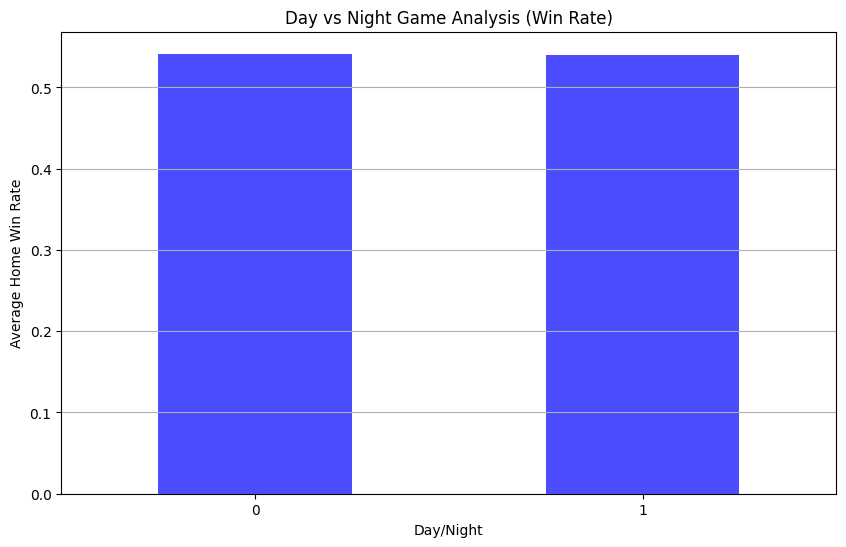

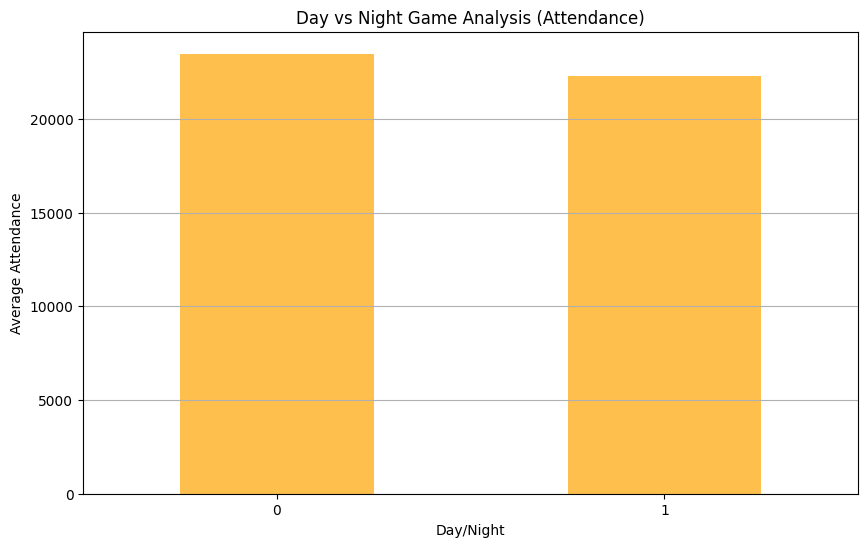

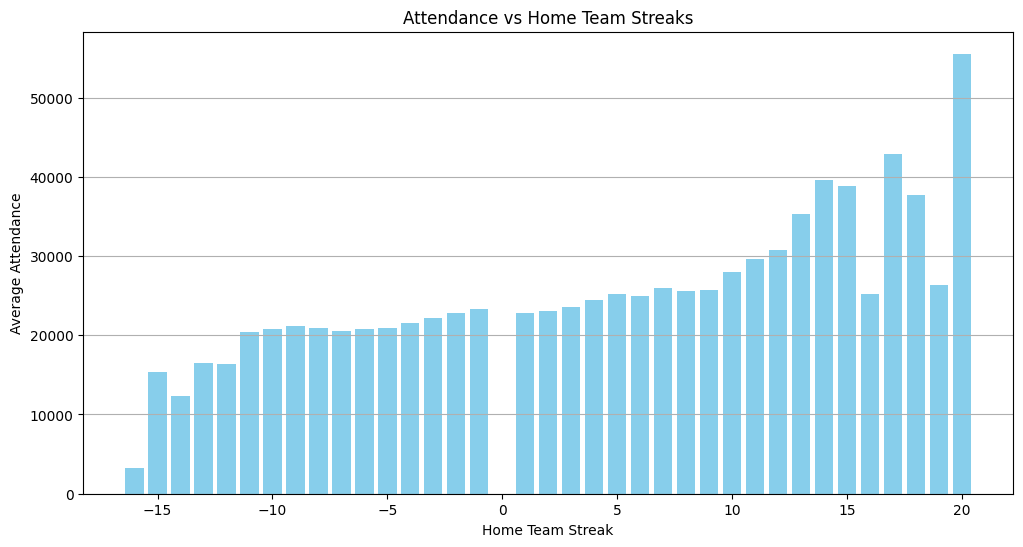

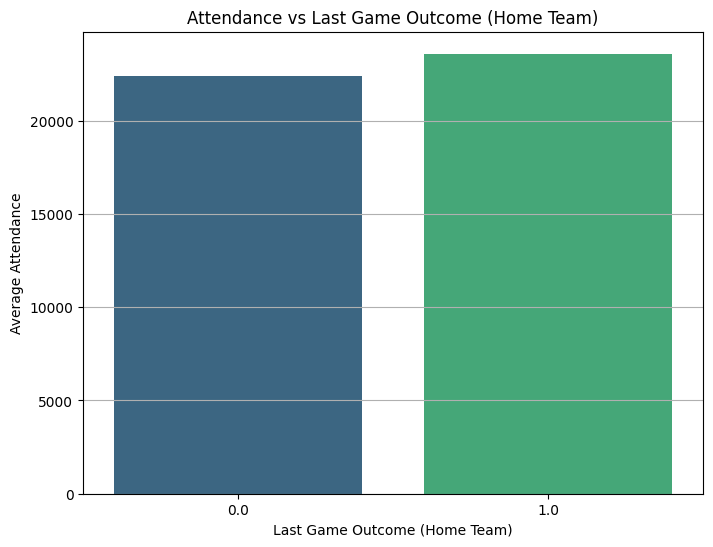

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure date is in datetime format
mlb_data['date'] = pd.to_datetime(mlb_data['date'], errors='coerce')

# Separate the plots into two for better visualization

# Plot 1: Average Home Win Rate
plt.figure(figsize=(10, 6))
day_night_win_rate['avg_home_win_rate'].plot(kind='bar', color='blue', alpha=0.7)
plt.title('Day vs Night Game Analysis (Win Rate)')
plt.ylabel('Average Home Win Rate')
plt.xlabel('Day/Night')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

# Plot 2: Average Attendance
plt.figure(figsize=(10, 6))
day_night_win_rate['avg_attendance'].plot(kind='bar', color='orange', alpha=0.7)
plt.title('Day vs Night Game Analysis (Attendance)')
plt.ylabel('Average Attendance')
plt.xlabel('Day/Night')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


# Attendance vs Streaks
attendance_streaks = mlb_data.groupby('h_streak').agg({'attendance': 'mean'}).reset_index()

plt.figure(figsize=(12, 6))
plt.bar(attendance_streaks['h_streak'], attendance_streaks['attendance'], color='skyblue')
plt.title('Attendance vs Home Team Streaks')
plt.xlabel('Home Team Streak')
plt.ylabel('Average Attendance')
plt.grid(axis='y')
plt.show()

# Attendance vs Last Game Outcome
attendance_last_outcome = mlb_data.groupby('h_last_game_outcome').agg({'attendance': 'mean'}).reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(data=attendance_last_outcome, x='h_last_game_outcome', y='attendance', palette='viridis')
plt.title('Attendance vs Last Game Outcome (Home Team)')
plt.xlabel('Last Game Outcome (Home Team)')
plt.ylabel('Average Attendance')
plt.grid(axis='y')
plt.show()


                Feature       VIF
0              h_streak  2.817229
1              v_streak  2.633655
2            attendance  3.376161
3            score_diff  2.468027
4              home_win  4.726120
5   h_last_game_outcome  2.390726
6  last_game_score_diff  2.458607
7             day_night  2.116987
8           day_of_week  6.019453


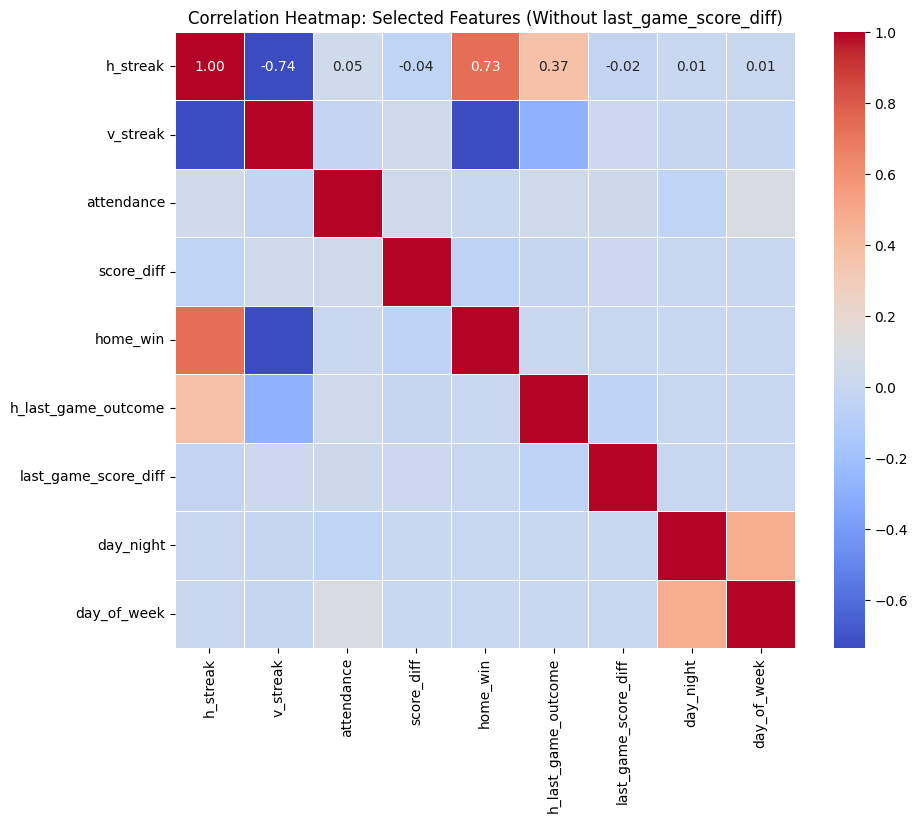

,h_last_game_outcome,last_game_score_diff,Loss Probability,Win Probability
0,0.0,0.0,0.509091,0.490909
1,0.0,1.0,0.467971,0.532029
2,0.0,2.0,0.457337,0.542663
3,0.0,3.0,0.462509,0.537491
4,0.0,4.0,0.448403,0.551597
5,0.0,5.0,0.489083,0.510917
6,0.0,6.0,0.479738,0.520262
7,0.0,7.0,0.503448,0.496552
8,0.0,8.0,0.459253,0.540747
9,0.0,9.0,0.503098,0.496902


In [60]:
mlb_data
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select relevant numerical columns for multicollinearity check
numerical_columns = ['h_streak', 'v_streak', 'attendance', 'score_diff', 'home_win', 'h_last_game_outcome', 'last_game_score_diff','day_night', 'day_of_week']
correlation_data = mlb_data[numerical_columns].dropna()
mlb_data.select_dtypes(include=['float64', 'int64']).columns

# Calculate Variance Inflation Factor (VIF)
vif_data = pd.DataFrame()
vif_data['Feature'] = correlation_data.columns
vif_data['VIF'] = [variance_inflation_factor(correlation_data.values, i) for i in range(correlation_data.shape[1])]
print(vif_data)

correlation_matrix = mlb_data[numerical_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap: Selected Features (Without last_game_score_diff)')
plt.show()

filtered_data = mlb_data.groupby(['h_last_game_outcome', 'last_game_score_diff']).filter(lambda x: len(x) >= 30)
cross_tab = pd.crosstab(
    index=[filtered_data['h_last_game_outcome'], filtered_data['last_game_score_diff']],
    columns=filtered_data['home_win'],
    normalize='index'
)

# Rename columns for clarity
cross_tab.columns = ['Loss Probability', 'Win Probability']
cross_tab.reset_index(inplace=True)

# Display the resulting cross-tabulation
cross_tab

In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Feature Selection
# Define the features to use for prediction
features = ['h_streak', 'v_streak', 'score_diff', 'h_last_game_outcome', 'last_game_score_diff', 'day_night', 'day_of_week']

# Ensure the target variable is binary (1 for home win, 0 for loss)
target = 'home_win'

# 2. Prepare the Data
# Filter the dataset to include only rows with non-null features and target
filtered_data = mlb_data.dropna(subset=features + [target])

# Define X (features) and y (target)
X = filtered_data[features]
y = filtered_data[target]

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Train the Model
# Initialize logistic regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# 4. Make Predictions
# Predict on the test set
y_pred = model.predict(X_test)

# 5. Evaluate the Model
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 6. Feature Importance
# Display feature coefficients (importance)
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Accuracy: 0.96

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      8528
           1       0.96      0.96      0.96     10050

    accuracy                           0.96     18578
   macro avg       0.96      0.96      0.96     18578
weighted avg       0.96      0.96      0.96     18578


Confusion Matrix:
[[8125  403]
 [ 379 9671]]

Feature Importance:
                Feature  Coefficient
0              h_streak     1.054369
4  last_game_score_diff     0.001571
5             day_night    -0.003787
6           day_of_week    -0.010812
2            score_diff    -0.029025
1              v_streak    -1.043027
3   h_last_game_outcome    -2.726426


In [62]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Feature Selection
# Define the features to use for prediction
features = ['h_streak', 'v_streak', 'score_diff', 'h_last_game_outcome', 'last_game_score_diff', 'day_night', 'day_of_week']

# Ensure the target variable is binary (1 for home win, 0 for loss)
target = 'home_win'

# 2. Prepare the Data
# Filter the dataset to include only rows with non-null features and target
filtered_data = mlb_data.dropna(subset=features + [target])

# Define X (features) and y (target)
X = filtered_data[features]
y = filtered_data[target]

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Train the Random Forest Model
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 4. Make Predictions
# Predict on the test set
y_pred = rf_model.predict(X_test)

# 5. Evaluate the Model
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 6. Feature Importance
# Extract feature importances
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

Accuracy: 0.95

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      8528
           1       0.96      0.96      0.96     10050

    accuracy                           0.95     18578
   macro avg       0.95      0.95      0.95     18578
weighted avg       0.95      0.95      0.95     18578


Confusion Matrix:
[[8098  430]
 [ 447 9603]]

Feature Importance:
                Feature  Importance
0              h_streak    0.484636
1              v_streak    0.423934
4  last_game_score_diff    0.026830
2            score_diff    0.026530
6           day_of_week    0.018481
3   h_last_game_outcome    0.016240
5             day_night    0.003349
